<a href="https://colab.research.google.com/github/benbatman/CNN_Projects/blob/main/food101_Resnet_vit_HuggingFace_Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers datasets evaluate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 28.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.8/462.8 KB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 KB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 47.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 7.3 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [2]:
# Import dependencies
import numpy as np 
import torch 
import torchvision 
from torchvision import datasets
from torchvision import transforms
from torch import nn 

assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"

print(f"PyTorch version: {torch.__version__}")
print(f"Torchvision version: {torchvision.__version__}")

PyTorch version: 1.13.1+cu116
Torchvision version: 0.14.1+cu116


In [3]:
# try: 
#   from torchinfo import summary  
# except: 
#   print("[INFO] Couldn't find torchinfo... installing it.")
#   !pip install -q torchinfo
#   from torchinfo import summary 

In [3]:
# Set the device 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
# Images already in tensors through manual transforms
# For completeness from HuggingFace tutorial
# Also gets mean and std normalization for images
from transformers import AutoImageProcessor
from transformers import AutoFeatureExtractor

# ViT model
vit_checkpoint = "google/vit-base-patch16-224"
image_processor = AutoImageProcessor.from_pretrained(vit_checkpoint)

# Resnet model
resnet_checkpoint = "microsoft/resnet-50"
feature_extractor = AutoFeatureExtractor.from_pretrained(resnet_checkpoint)
feature_extractor

/usr/local/lib/python3.8/dist-packages/transformers/models/convnext/feature_extraction_convnext.py:28: FutureWarning: The class ConvNextFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ConvNextImageProcessor instead.
  warnings.warn(


ConvNextFeatureExtractor {
  "crop_pct": 0.875,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "feature_extractor_type": "ConvNextFeatureExtractor",
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "ConvNextFeatureExtractor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "shortest_edge": 224
  }
}

In [5]:
# Get dataset from HuggingFace
from datasets import load_dataset

# Will just get 10000 of the samples for now to test with 
food101_dataset = load_dataset("food101", split="train[:30000]")
food101_dataset = food101_dataset.train_test_split(test_size=0.2)

# # Get the dataset and apply transforms defined above with torchvision datasets
# food101_train_dataset = torchvision.datasets.Food101("data", split='train', 
#                                                transform = train_transforms,
#                                                download=True, 
#                                                target_transform=None)

# food101_test_dataset = torchvision.datasets.Food101("data", split='test', 
#                                                transform = test_transforms,
#                                                download=True, 
#                                                target_transform=None)

Computing checksums: 100%|##########| 1/1 [00:16<00:00, 16.45s/it]

Generating train split:   0%|          | 0/75750 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/25250 [00:00<?, ? examples/s]

Dataset food101 downloaded and prepared to /root/.cache/huggingface/datasets/food101/default/0.0.0/7cebe41a80fb2da3f08fcbef769c8874073a86346f7fb96dc0847d4dfc318295. Subsequent calls will reuse this data.


In [8]:
food101_dataset['train']

Dataset({
    features: ['image', 'label'],
    num_rows: 24000
})

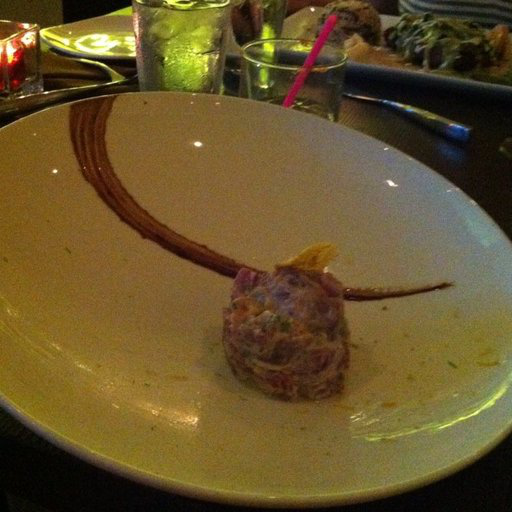

In [24]:
# Look at one sample
food101_dataset['train'][3]['image']

In [26]:
len(food101_dataset['train'])

24000

In [19]:
# Get list of labels
labels = food101_dataset['train'].features['label'].names
labels

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheesecake',
 'cheese_plate',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

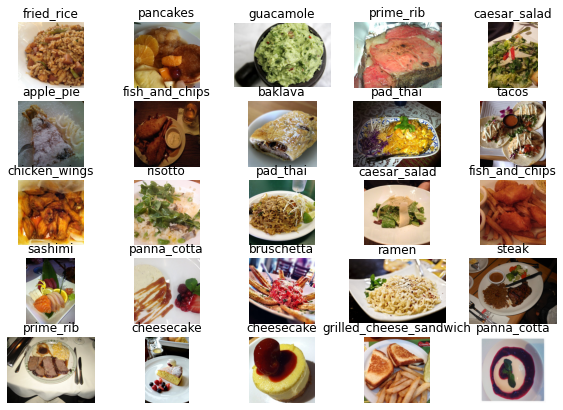

In [27]:
# Plot some random images from the dataset
import matplotlib.pyplot as plt 
import random
import PIL

# Code for HuggingFace dataset
fig = plt.figure(figsize=(10,7))
r, c = 5,5
for i in range(1, r*c+1):
  rand_idx = random.randint(0, len(food101_dataset['train']))
  image, label = food101_dataset['train'][rand_idx]['image'], food101_dataset['train'][rand_idx]['label']
  fig.add_subplot(r,c,i)
  plt.imshow(np.array(image).squeeze())
  plt.title(labels[label])
  plt.axis(False)


# Code for PyTorch dataset
# fig = plt.figure(figsize=(10,7))
# r, c = 5,5
# for i in range(1, r*c+1):
#   rand_idx = random.randint(0, len(food101_train_dataset))
#   image, label = food101_train_dataset[rand_idx]
#   fig.add_subplot(r,c,i)
#   plt.imshow(image.permute(1,2,0).squeeze())
#   plt.title(classes[label])
#   plt.axis(False)

In [28]:
from torchvision.transforms import RandomResizedCrop, Compose, Normalize, RandomHorizontalFlip

# Create image size (scaling down), size resnet model was trained on
IMG_SIZE = (224, 224)

vit_normalizer = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
resnet_normalizer = Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)

# Create transform pipeline manually to make some initial transformations upon loading data in
train_transforms = transforms.Compose([ 
    #transforms.Resize(IMG_SIZE), 
    RandomResizedCrop(IMG_SIZE),
    RandomHorizontalFlip(),
    transforms.ToTensor(),
    resnet_normalizer
])

test_transforms = transforms.Compose([ 
    transforms.Resize(IMG_SIZE), 
    transforms.ToTensor(),
    resnet_normalizer
])
print(f"Train transforms: {train_transforms}")
print(f"Test transforms: {test_transforms}")

Train transforms: Compose(
    RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear), antialias=None)
    RandomHorizontalFlip(p=0.5)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
Test transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


In [29]:
def train_preprocess(example_batch):
  example_batch["pixel_values"] = [train_transforms(img.convert("RGB")) for img in example_batch["image"]]
  del example_batch['image']
  return example_batch

def val_preprocess(example_batch):
  example_batch['pixel_values'] = [test_transforms(img.convert("RGB")) for img in example_batch['image']]
  del example_batch['image']
  return example_batch

In [30]:
# Get training and testing data 
train_data = food101_dataset['train']
val_data = food101_dataset['test']

train_data, val_data

(Dataset({
     features: ['image', 'label'],
     num_rows: 24000
 }), Dataset({
     features: ['image', 'label'],
     num_rows: 6000
 }))

In [31]:
# Perform inplace image transformation 
train_data.set_transform(train_preprocess)
val_data.set_transform(val_preprocess)

In [32]:
train_data[0]

{'label': 86,
 'pixel_values': tensor([[[ 0.2453,  0.2453,  0.2967,  ...,  1.8722,  1.8722,  1.8550],
          [ 0.5022,  0.5193,  0.5536,  ...,  1.8722,  1.8893,  1.8722],
          [ 0.5193,  0.5364,  0.6049,  ...,  1.8893,  1.9064,  1.8893],
          ...,
          [ 1.6324,  1.5982,  1.5639,  ...,  1.6838,  1.6838,  1.7009],
          [ 1.7694,  1.7694,  1.7009,  ...,  1.6667,  1.6838,  1.7180],
          [ 1.7865,  1.8037,  1.7865,  ...,  1.7009,  1.7352,  1.7865]],
 
         [[-0.1275, -0.0924, -0.0574,  ...,  1.9209,  1.9384,  1.9209],
          [ 0.0476,  0.0651,  0.1001,  ...,  1.9209,  1.9384,  1.9209],
          [ 0.0651,  0.0826,  0.1352,  ...,  1.9209,  1.9209,  1.9209],
          ...,
          [ 1.4832,  1.4307,  1.3957,  ...,  1.6057,  1.5882,  1.6232],
          [ 1.6408,  1.6057,  1.5357,  ...,  1.5882,  1.5882,  1.6232],
          [ 1.6933,  1.6583,  1.6408,  ...,  1.6057,  1.6408,  1.6933]],
 
         [[-0.3578, -0.3404, -0.3055,  ...,  1.6465,  1.6640,  1.6814]

In [37]:
# If we wanted to undo the normalization to get back original images
invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                     std = [ 1., 1., 1. ]),
                               ])

In [ ]:
# Plot random images after transforming
# Won't be great because of the normalization applied (values aren't between [0,1])
fig = plt.figure(figsize=(10,7))
r, c = 5,5
for i in range(1, r*c+1):
  rand_idx = random.randint(0, len(train_data))
  image, label = train_data[rand_idx]['pixel_values'], train_data[rand_idx]['label']
  fig.add_subplot(r,c,i)
  plt.imshow(np.moveaxis(np.array(image), 0, -1).squeeze())
  plt.title(labels[label])
  plt.axis(False)

In [ ]:
# # Look at one example of image and associated label (if retrived data with PyTorch)
# image, label = food101_train_dataset[0]
# image, label, image.shape

In [12]:
# How many samples are there in the train and test sets? PyTorch
#len(food101_train_dataset), len(food101_test_dataset)

In [17]:
from transformers import DefaultDataCollator
# Create data collator
data_collator = DefaultDataCollator(return_tensors='pt')

In [ ]:
# What are all the classes (PyTorch)
# classes = food101_train_dataset.classes
# classes

In [40]:
# How many training samples
len(train_data)

24000

In [41]:
train_data[0]['pixel_values']

tensor([[[ 1.9749,  1.9749,  1.9749,  ...,  0.1768,  0.1426,  0.1254],
         [ 2.0092,  2.0092,  2.0092,  ..., -0.0116, -0.0458,  0.0227],
         [ 2.0092,  1.9920,  1.9920,  ...,  0.0398,  0.0398,  0.1083],
         ...,
         [ 1.6324,  1.5982,  1.5297,  ...,  1.7523,  1.7694,  1.8722],
         [ 1.6153,  1.6153,  1.5982,  ...,  1.9064,  1.9578,  2.0263],
         [ 1.5810,  1.6495,  1.6324,  ...,  2.0948,  2.1290,  2.1290]],

        [[ 2.0259,  2.0259,  2.0259,  ..., -0.8102, -0.8452, -0.8277],
         [ 2.0609,  2.0609,  2.0609,  ..., -1.0028, -1.0378, -0.9328],
         [ 2.0434,  2.0434,  2.0434,  ..., -0.9153, -0.9328, -0.8277],
         ...,
         [-0.6702, -0.6352, -0.6527,  ...,  1.7108,  1.7458,  1.8508],
         [-0.7227, -0.6702, -0.6352,  ...,  1.8859,  1.9384,  2.0434],
         [-0.8277, -0.7052, -0.6527,  ...,  2.0609,  2.1310,  2.1310]],

        [[ 1.7511,  1.7511,  1.7860,  ..., -0.2881, -0.3404, -0.3753],
         [ 1.8034,  1.8034,  1.8208,  ..., -0

In [42]:
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
  label2id[label] = str(i)
  id2label[str(i)] = label

In [43]:
label2id, id2label

({'apple_pie': '0',
  'baby_back_ribs': '1',
  'baklava': '2',
  'beef_carpaccio': '3',
  'beef_tartare': '4',
  'beet_salad': '5',
  'beignets': '6',
  'bibimbap': '7',
  'bread_pudding': '8',
  'breakfast_burrito': '9',
  'bruschetta': '10',
  'caesar_salad': '11',
  'cannoli': '12',
  'caprese_salad': '13',
  'carrot_cake': '14',
  'ceviche': '15',
  'cheesecake': '16',
  'cheese_plate': '17',
  'chicken_curry': '18',
  'chicken_quesadilla': '19',
  'chicken_wings': '20',
  'chocolate_cake': '21',
  'chocolate_mousse': '22',
  'churros': '23',
  'clam_chowder': '24',
  'club_sandwich': '25',
  'crab_cakes': '26',
  'creme_brulee': '27',
  'croque_madame': '28',
  'cup_cakes': '29',
  'deviled_eggs': '30',
  'donuts': '31',
  'dumplings': '32',
  'edamame': '33',
  'eggs_benedict': '34',
  'escargots': '35',
  'falafel': '36',
  'filet_mignon': '37',
  'fish_and_chips': '38',
  'foie_gras': '39',
  'french_fries': '40',
  'french_onion_soup': '41',
  'french_toast': '42',
  'fried_ca

In [35]:
# Code to turn PyTorch dataset into an iterable dataset

# import math
# class MyIterableDataset(torch.utils.data.IterableDataset):
#   def __init__(self, dataset, start, end):
#     super(MyIterableDataset).__init__()
#     assert end > start, "this example code only works with end >= start"
#     self.start = start
#     self.end = end
#     self.dataset = dataset

#   def __iter__(self):
#     worker_info = torch.utils.data.get_worker_info()
#     if worker_info is None:  # single-process data loading, return the full iterator
#         iter_start = self.start
#         iter_end = self.end
#     else:  # in a worker process
#         # split workload
#         per_worker = int(math.ceil((self.end - self.start) / float(worker_info.num_workers)))
#         worker_id = worker_info.id
#         iter_start = self.start + worker_id * per_worker
#         iter_end = min(iter_start + per_worker, self.end)
#     return iter(range(iter_start, iter_end))

#   def __len__(self):
#     return len(self.dataset)

#   def __dict__(self):
#     for image, label in self.dataset:
#       return {"data":image, "label":label}

# # should give same set of data as range(3, 7), i.e., [3, 4, 5, 6].
# train_data = MyIterableDataset(food101_train_dataset, start=0, end=len(food101_train_dataset))

# test_data = MyIterableDataset(food101_test_dataset, start=0, end=len(food101_test_dataset))


In [31]:
# from torch.utils.data import DataLoader
# from torch.utils.data.sampler import BatchSampler, RandomSampler
# import os

# # Create training and testing dataloaders and apply more transforms to the images 

# BATCH_SIZE = 32 # set batch size hyperparameter 

# # If data was just a regular directory
# # Turn into torchvision dataset and apply appropiate transforms
# # train_data = datasets.ImageFolder(train_dir, transforms)
# # test_data = datasets.ImageFolder(test_dir, transforms)

# # batch_sampler = BatchSampler(RandomSampler(food101_train_dataset), 
# #                               batch_size=BATCH_SIZE, drop_last=False)

# train_dataloader = DataLoader(food101_train_dataset,
#                               batch_size=BATCH_SIZE, # samples per batch
#                               shuffle=True, # Shuffle the data every epoch
#                               num_workers=os.cpu_count(),
#                               #batch_sampler=batch_sampler
#                               )

# test_dataloader = DataLoader(food101_test_dataset,
#                              batch_size=BATCH_SIZE,
#                              shuffle=False # Don't need to shuffle test data
#                              #batch_sampler=batch_sampler
#                              )
# # Print out everything 
# print(f"Dataloaders: {train_dataloader, test_dataloader}")
# print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
# print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x7f92580ddd30>, <torch.utils.data.dataloader.DataLoader object at 0x7f92580dd9a0>)
Length of train dataloader: 2368 batches of 32
Length of test dataloader: 790 batches of 32


In [25]:
# See what's inside of the dataloaders 
# train_features_batch, train_labels_batch = next(iter(train_dataloader))
# train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32]))

In [44]:
# Create evaluation metric
# Multiple ways to do this 
# From HugggingFace
import evaluate 

accuracy = evaluate.load("accuracy")

# Or we could create our own accuracy function
def accuracy_fn(y_true, y_pred):
  """
  Takes in ground-truth values and predicated values and returns the accuracy
  """
  correct = torch.eq(y_true, y_pred).sum().item() # how many preds are correct
  acc = (correct / len(y_pred)) * 100 # get the accuracy score 
  return acc 

In [45]:
def compute_metrics(eval_pred):
  predictions, labels = eval_pred 
  predictions = np.argmax(predictions, axis=1) 
  return accuracy.compute(predictions=predictions, references=labels)

In [46]:
len(labels)

101

In [47]:
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer
from transformers import ViTFeatureExtractor, ViTForImageClassification

# feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')
# model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')

# Build the model with resnet architecture and weights
resnet_model = AutoModelForImageClassification.from_pretrained(
    resnet_checkpoint, # resnet model
    num_labels=len(labels),
    ignore_mismatched_sizes=True, # trained on ImageNet with 1000 classes
    id2label=id2label,
    label2id=label2id
)

Some weights of ResNetForImageClassification were not initialized from the model checkpoint at microsoft/resnet-50 and are newly initialized because the shapes did not match:
- classifier.1.weight: found shape torch.Size([1000, 2048]) in the checkpoint and torch.Size([101, 2048]) in the model instantiated
- classifier.1.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([101]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [48]:
import torch

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

In [53]:
# Define callback 
import transformers
early_stopping = transformers.EarlyStoppingCallback(early_stopping_patience=3, 
                                                     early_stopping_threshold=0.01)

In [54]:
# Define training hyperparameters with HuggingFace's TrainingArguments
import transformers
# output directories for models trained 
output_dir_vit = "food101_ViT_model_1"
output_dir_resnet = "food101_resnet_model_1"

BATCH_SIZE = 32

training_args = TrainingArguments(
    output_dir=output_dir_resnet,
    remove_unused_columns=False, 
    evaluation_strategy='epoch',
    save_strategy='epoch',
    learning_rate=5e-4, # smaller learning rate for transfer learning
    per_device_train_batch_size=BATCH_SIZE,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=10,
    warmup_ratio=0.1, # linear warmup to reduce volatility in early stages of training
    logging_strategy='steps',
    logging_steps=10,
    load_best_model_at_end=True, 
    metric_for_best_model='accuracy',
    push_to_hub=False
)

trainer = Trainer(
    model=resnet_model, 
    args=training_args, 
    data_collator=collate_fn,
    train_dataset=train_data,
    eval_dataset=val_data,
    tokenizer=feature_extractor,
    compute_metrics=compute_metrics,
    callbacks=[early_stopping]
    )
                                
train_results = trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running training *****
  Num examples = 24000
  Num Epochs = 10
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 4
  Total optimization steps = 1870
  Number of trainable parameters = 23714981


Epoch,Training Loss,Validation Loss,Accuracy
0,2.013100,1.588414,0.550667
1,1.358400,0.976242,0.719000
2,1.029700,0.835616,0.758000
3,0.968600,0.762608,0.780000
4,0.893900,0.719076,0.797000
5,0.747900,0.698628,0.798833
6,0.764700,0.683579,0.806500
7,0.671000,0.665371,0.810000


***** Running Evaluation *****
  Num examples = 6000
  Batch size = 32
Saving model checkpoint to food101_resnet_model_1/checkpoint-187
Configuration saved in food101_resnet_model_1/checkpoint-187/config.json
Model weights saved in food101_resnet_model_1/checkpoint-187/pytorch_model.bin
Image processor saved in food101_resnet_model_1/checkpoint-187/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 6000
  Batch size = 32
Saving model checkpoint to food101_resnet_model_1/checkpoint-374
Configuration saved in food101_resnet_model_1/checkpoint-374/config.json
Model weights saved in food101_resnet_model_1/checkpoint-374/pytorch_model.bin
Image processor saved in food101_resnet_model_1/checkpoint-374/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 6000
  Batch size = 32
Saving model checkpoint to food101_resnet_model_1/checkpoint-561
Configuration saved in food101_resnet_model_1/checkpoint-561/config.json
Model weights saved in food101_resnet_m

***** train metrics *****
  epoch                    =          8.0
  total_flos               = 3829946272GF
  train_loss               =        1.266
  train_runtime            =   1:00:55.93
  train_samples_per_second =       65.647
  train_steps_per_second   =        0.511


In [66]:
val_data[0]['label']

57

In [68]:
val_ds = load_dataset("food101", split='validation[:10]')
val_ds

Dataset({
    features: ['image', 'label'],
    num_rows: 10
})

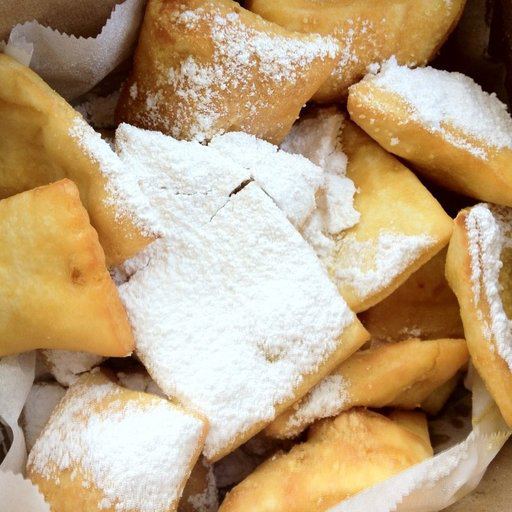

In [71]:
val_ds[2]['image']

loading configuration file food101_resnet_model_1/preprocessor_config.json
/usr/local/lib/python3.8/dist-packages/transformers/models/convnext/feature_extraction_convnext.py:28: FutureWarning: The class ConvNextFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ConvNextImageProcessor instead.
  warnings.warn(
Image processor ConvNextFeatureExtractor {
  "crop_pct": 0.875,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "feature_extractor_type": "ConvNextFeatureExtractor",
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "ConvNextFeatureExtractor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "shortest_edge": 224
  }
}



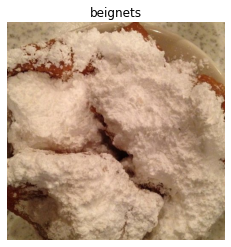

In [76]:
from transformers import AutoImageProcessor 
import torch 

rand_idx = random.randint(0, len(val_ds))
rand_image = val_ds[rand_idx]['image']
rand_label = val_ds[rand_idx]['label']

image_processor = AutoImageProcessor.from_pretrained(output_dir_resnet)
inputs = image_processor(rand_image, return_tensors="pt")

plt.imshow(np.array(rand_image))
plt.title(id2label[str(rand_label)])
plt.axis(False);

In [78]:
model = AutoModelForImageClassification.from_pretrained(output_dir_resnet)
model(**inputs).logits

loading configuration file food101_resnet_model_1/config.json
Model config ResNetConfig {
  "_name_or_path": "food101_resnet_model_1",
  "architectures": [
    "ResNetForImageClassification"
  ],
  "depths": [
    3,
    4,
    6,
    3
  ],
  "downsample_in_first_stage": false,
  "embedding_size": 64,
  "hidden_act": "relu",
  "hidden_sizes": [
    256,
    512,
    1024,
    2048
  ],
  "id2label": {
    "0": "apple_pie",
    "1": "baby_back_ribs",
    "2": "baklava",
    "3": "beef_carpaccio",
    "4": "beef_tartare",
    "5": "beet_salad",
    "6": "beignets",
    "7": "bibimbap",
    "8": "bread_pudding",
    "9": "breakfast_burrito",
    "10": "bruschetta",
    "11": "caesar_salad",
    "12": "cannoli",
    "13": "caprese_salad",
    "14": "carrot_cake",
    "15": "ceviche",
    "16": "cheesecake",
    "17": "cheese_plate",
    "18": "chicken_curry",
    "19": "chicken_quesadilla",
    "20": "chicken_wings",
    "21": "chocolate_cake",
    "22": "chocolate_mousse",
    "23": "chu

tensor([[ 3.3288, -6.0768,  0.1502, -5.7282, -5.9291, -2.1951,  9.8813, -6.0671,
         -5.8876, -5.8862, -1.2713, -0.2652, -5.9526, -6.2610,  0.0972, -6.1720,
         -0.1762, -6.1145, -6.0380, -5.8953,  1.9743,  0.9713,  0.6458, -6.0449,
         -5.7794, -5.8351, -5.7610, -6.0576, -6.2759, -5.9221, -5.9118, -6.4056,
         -6.0626, -6.2471, -3.1792, -5.9500, -5.9283, -6.2751, -0.2048, -0.3161,
         -5.9832, -5.7271, -5.9044,  1.2373, -1.7036, -5.9325,  0.2521, -6.3328,
         -1.4489, -1.9706, -5.7548, -1.0103, -6.2451, -0.4809, -6.2428, -1.3278,
         -6.2120,  1.3743,  2.4468, -0.7351, -5.9301, -6.1285, -6.0333, -6.1784,
         -1.5062, -5.9635, -6.0960, -5.9504, -5.9542, -6.0432, -4.2129, -5.5577,
          1.0995,  0.3044, -5.9025, -5.8822, -1.8751, -1.2162, -5.9052, -0.4753,
         -5.9071, -1.4887, -6.2065, -0.9989, -2.2208, -6.0957, -1.8819, -5.9483,
         -5.9968, -5.8172, -5.4288, -6.0713, -6.2466, -0.7954, -5.7474, -5.8896,
         -1.2333, -5.9195,  

In [83]:
logits.argmax(-1), np.argmax(logits)

(tensor([6]), tensor(6))

In [84]:
from transformers import AutoModelForImageClassification

model = AutoModelForImageClassification.from_pretrained(output_dir_resnet)
with torch.inference_mode():
  logits = model(**inputs).logits

predicted_label = logits.argmax(-1).item()
print(id2label[str(predicted_label)])

loading configuration file food101_resnet_model_1/config.json
Model config ResNetConfig {
  "_name_or_path": "food101_resnet_model_1",
  "architectures": [
    "ResNetForImageClassification"
  ],
  "depths": [
    3,
    4,
    6,
    3
  ],
  "downsample_in_first_stage": false,
  "embedding_size": 64,
  "hidden_act": "relu",
  "hidden_sizes": [
    256,
    512,
    1024,
    2048
  ],
  "id2label": {
    "0": "apple_pie",
    "1": "baby_back_ribs",
    "2": "baklava",
    "3": "beef_carpaccio",
    "4": "beef_tartare",
    "5": "beet_salad",
    "6": "beignets",
    "7": "bibimbap",
    "8": "bread_pudding",
    "9": "breakfast_burrito",
    "10": "bruschetta",
    "11": "caesar_salad",
    "12": "cannoli",
    "13": "caprese_salad",
    "14": "carrot_cake",
    "15": "ceviche",
    "16": "cheesecake",
    "17": "cheese_plate",
    "18": "chicken_curry",
    "19": "chicken_quesadilla",
    "20": "chicken_wings",
    "21": "chocolate_cake",
    "22": "chocolate_mousse",
    "23": "chu

beignets


In [86]:
# Alternate way to perform inference using HuggingFace's pipeline API
from transformers import pipeline 

classifier = pipeline("image-classification", model=output_dir_resnet)
classifier(rand_image)

loading configuration file food101_resnet_model_1/config.json
Model config ResNetConfig {
  "_name_or_path": "food101_resnet_model_1",
  "architectures": [
    "ResNetForImageClassification"
  ],
  "depths": [
    3,
    4,
    6,
    3
  ],
  "downsample_in_first_stage": false,
  "embedding_size": 64,
  "hidden_act": "relu",
  "hidden_sizes": [
    256,
    512,
    1024,
    2048
  ],
  "id2label": {
    "0": "apple_pie",
    "1": "baby_back_ribs",
    "2": "baklava",
    "3": "beef_carpaccio",
    "4": "beef_tartare",
    "5": "beet_salad",
    "6": "beignets",
    "7": "bibimbap",
    "8": "bread_pudding",
    "9": "breakfast_burrito",
    "10": "bruschetta",
    "11": "caesar_salad",
    "12": "cannoli",
    "13": "caprese_salad",
    "14": "carrot_cake",
    "15": "ceviche",
    "16": "cheesecake",
    "17": "cheese_plate",
    "18": "chicken_curry",
    "19": "chicken_quesadilla",
    "20": "chicken_wings",
    "21": "chocolate_cake",
    "22": "chocolate_mousse",
    "23": "chu

[{'score': 0.9960856437683105, 'label': 'beignets'},
 {'score': 0.0014209210639819503, 'label': 'apple_pie'},
 {'score': 0.0005882144905626774, 'label': 'ice_cream'},
 {'score': 0.00036670928238891065, 'label': 'chicken_wings'},
 {'score': 0.0002012520271819085, 'label': 'hummus'}]

## ViT Model 

Will be training a ViT model with same parameters to see which model performs better

In [ ]:
# Create transform pipeline manually to make some initial transformations upon loading data in
train_transforms = transforms.Compose([ 
    #transforms.Resize(IMG_SIZE), 
    RandomResizedCrop(IMG_SIZE),
    RandomHorizontalFlip(),
    transforms.ToTensor(),
    vit_normalizer
])

test_transforms = transforms.Compose([ 
    transforms.Resize(IMG_SIZE), 
    transforms.ToTensor(),
    vit_normalizer
])
print(f"Train transforms: {train_transforms}")
print(f"Test transforms: {test_transforms}")

In [ ]:
def train_preprocess(example_batch):
  example_batch["pixel_values"] = [train_transforms(img.convert("RGB")) for img in example_batch["image"]]
  del example_batch['image']
  return example_batch

def val_preprocess(example_batch):
  example_batch['pixel_values'] = [test_transforms(img.convert("RGB")) for img in example_batch['image']]
  del example_batch['image']
  return example_batch

In [ ]:
# Get training and testing data 
train_data = food101_dataset['train']
val_data = food101_dataset['test']

train_data, val_data

In [ ]:
train_data.set_transform(train_preprocess)
val_data.set_transform(val_preprocess)